In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pypdf
import torch.nn.functional as F
import numpy as np
import os

In [2]:
df = pd.read_csv(r'C:\Users\Rick\lulu\Indian-Male-Names.csv',index_col=False)
df = df.drop('gender',axis = 1)
df

,name,race
0,barjraj,indian
1,ramdin verma,indian
2,sharat chandran,indian
3,birender mandal,indian
4,amit,indian
...,...,...
14840,buddha,indian
14841,mukesh,indian
14842,monu,indian
14843,govind prasad shahu,indian


In [5]:
df = df.drop('race',axis = 1)


In [30]:
df

,name
0,barjraj
1,ramdin verma
2,sharat chandran
3,birender mandal
4,amit
...,...
14840,buddha
14841,mukesh
14842,monu
14843,govind prasad shahu


In [6]:
df = df.drop_duplicates()

In [7]:
df.to_csv('Names_to_train.txt', index=False, header=False)

In [15]:
char_to_rem = '/\`0123456789@.,;}-()&"[]{}' + 'अआइईउऊएऐओऔऋअंकखगघड़चछजझञटठडढणतथदधनपफबभमयरलवशषसह' + 'ा' + 'ि' + 'ी' + 'ु' + 'ू' + 'े' + 'ो' + '्' + '\u200d' + '�'

def clean_char(name_of_folder):
    with open(name_of_folder, "r", encoding='utf-8') as f:
        content = f.read()
    cleaned_text = ''.join(char for char in content if char not in char_to_rem)
    
    lines = cleaned_text.split('\n') 
    processed_lines = []
    
    for line in lines:
        words = line.split()
        if words:  
            processed_line = ' '.join(words)  
            processed_lines.append(processed_line)

    final_output = '\n'.join(processed_lines)
    
    with open("cleaned_words.txt", "w", encoding='utf-8') as f:
        f.write(final_output)

clean_char("Names_to_train.txt")


<>:1: SyntaxWarning: invalid escape sequence '\`'
<>:1: SyntaxWarning: invalid escape sequence '\`'
C:\Users\Rick\AppData\Local\Temp\ipykernel_4044\3262600791.py:1: SyntaxWarning: invalid escape sequence '\`'
  char_to_rem = '/\`0123456789@.,;}-()&"[]{}' + 'अआइईउऊएऐओऔऋअंकखगघड़चछजझञटठडढणतथदधनपफबभमयरलवशषसह' + 'ा' + 'ि' + 'ी' + 'ु' + 'ू' + 'े' + 'ो' + '्' + '\u200d' + '�'


In [3]:
with open('cleaned_words.txt','r',encoding='utf-8')as f:
    data = f.read()
    words = data.splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}


In [4]:
block_size = 3 
X, Y = [], []
for w in words:
  #print(w)
  
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [74]:
generator = torch.manual_seed(6)
C = torch.randn(28,4)
w1= torch.randn((12,100))
b1 = torch.randn(100)
w2 = torch.randn((100,28))
b2 = torch.randn(28)
parameters = [C, w1, b1, w2, b2]

In [75]:
for p in parameters:
  p.requires_grad = True

In [76]:
sum(p.nelement() for p in parameters)

4240

In [77]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [78]:
lri = []
lossi = []
stepi = []

In [81]:
for i in range(10000):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (100,))
  
  # forward pass
  emb = C[X_train[ix]] # (32, 3, 4) (Minibatch for only 32 examples)
  h = torch.tanh(emb.view(-1, 12) @ w1 + b1) # (32, 200)
  logits = h @ w2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, y_train[ix])
  print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  #stepi.append(i)
  #lossi.append(loss.item())


2.245276689529419
1.8597838878631592
2.0248944759368896
2.2194042205810547
2.4011452198028564
2.149260997772217
2.1934711933135986
2.087461471557617
2.0339157581329346
2.2409958839416504
2.0857763290405273
2.2322781085968018
1.9452656507492065
2.142345666885376
2.216336965560913
2.251650094985962
2.4817745685577393
2.0433261394500732
2.0262043476104736
2.354208469390869
2.093289852142334
1.9957340955734253
2.3055646419525146
2.3624002933502197
2.3407468795776367
2.2099010944366455
1.9972268342971802
1.9896705150604248
2.283188581466675
2.3310163021087646
2.1609299182891846
2.024787187576294
2.165255069732666
2.051431655883789
2.3299288749694824
2.066619634628296
2.2262158393859863
2.4608662128448486
2.2977592945098877
2.3474714756011963
2.153254747390747
2.0741002559661865
2.1450483798980713
2.368151903152466
2.1888017654418945
2.050952672958374
2.0372185707092285
2.121975898742676
2.1238725185394287
2.2423713207244873
1.9349300861358643
2.235177993774414
2.048757553100586
2.1168270111

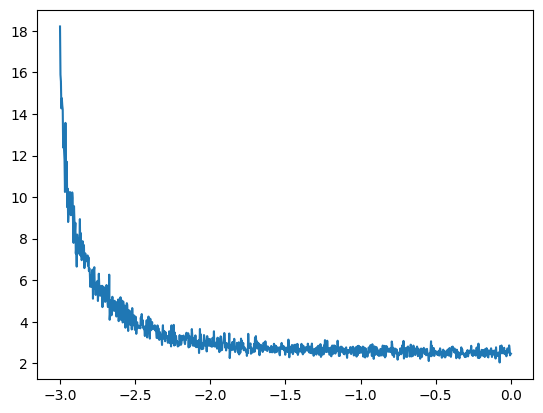

In [68]:
plt.plot(lri, lossi)

In [73]:
g = torch.Generator().manual_seed(6 + 10)

for _ in range(50):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ w1 + b1)
      logits = h @ w2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

dhishataot mwal.
deepramnantursingh.
fay.
veem.
jatu.
ramesh.
mohd singh nal.
rajesh soni.
chhil paradeesh anjeenu.
bachheech.
dhi.
moham danikram singh.
nitwaresh sam.
adil.
indar larma.
kitsudharu.
sanju.
sehtajra.
ash.
jinder jishander pal shar pahd.
babarbi pal sonla.
nari.
il kumar.
bipaswar.
ram.
ram.
sanka riwek red gupta.
pandhu mohd.
jrirendranul kha.
shaprumendri.
aji.
laleet krishankalu.
yohsandra sharkan.
kir mander.
ijramneky.
rajayamunckyjant.
md kamlarkashi.
kapash mohish share mam pular hishakirishaih.
deviwal.
ram.
sanshik.
dherma.
sahij jaf.
shahda.
indra sabi.
narojit.
gula.
nhipin yaduravlal.
ankeev.
gafgi.
